In [190]:
import numpy as np
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
import functools as ftls
import networkx as nx
import copy
from itertools import combinations
%matplotlib inline
import sys
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))
np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0.0, 1.0], [1.0, 0.0]])
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.array([[1.0, 0.0], [0.0, 1.0]])

In [195]:
def new_graph(d, n):
    graph = nx.random_regular_graph(d, n)
    return graph, d, n

def isomorphism_check(x, y):
    isomorphic = nx.is_isomorphic(x, y)
    return isomorphic

def is_graph_connected(g):
    connected = nx.is_connected(g)
    return connected

def is_graph_regular(g, k):
    regular = nx.is_k_regular(g, k)
    return regular

def generate_graphs(num_edges, num_nodes, num_graphs):
    graph_list = []
    connected_graphs = []
    regular_graphs = []
    graph_only =[]
    if num_nodes < 4 and num_edges < 2:
        graph_only.append(new_graph(num_edges,num_nodes))
        return graph_only
    else :
        for i in range(num_graphs):
            graph_list.append(new_graph(num_edges,num_nodes))
        for i in range(len(graph_list)):
            if (is_graph_regular(graph_list[i][0], num_edges)):
                regular_graphs.append(graph_list[i])
        for i in range(len(regular_graphs)):
            if (is_graph_connected(regular_graphs[i][0])):
                connected_graphs.append(regular_graphs[i])
        check = True
        graphs = copy.deepcopy(connected_graphs)
        while (check) and (len(graphs) > 1):
            for i, j in combinations(graphs, 2):
                check = isomorphism_check(i[0], j[0])
                if check:
                    graphs.remove(i)
                    break
        return graphs

In [214]:
def MaxCut_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    for edge in edges:
        edge = np.sort(edge)
        H_problem += np.real(ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, 
                                   np.eye(2**(edge[1]-edge[0]-1)),
                                   operator, np.eye(2**(qubits-edge[1]-1))]))
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    print(edges_c)
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += 3 * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def Hamiltonian_d(qubits, operator):
    H_driver = np.zeros([2**qubits]*2, dtype = operator.dtype)
    for j in range(qubits):
        H_driver += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    return H_driver

def eigenVectors(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenVectors

def eigenValues(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues

def commutator(A, B, anti = False):
    if not anti:
        return A @ B - B @ A
    elif anti:
        return A @ B + B @ A

def exeFALQON(graphs, qubits):
    h_p_values = []
    graph_for_FALQON =[]
    g = 0
    print(len(graphs))
    for g in range(len(graphs)):
        graph_for_FALQON = graphs[g]
        #H_p = MaxCut_p(graph_for_FALQON[0].edges, qubits, Z)
        H_p = MaxClique_p(graph_for_FALQON[0].edges, qubits, Z)
        h_p_values.append(H_p)
        H_d = Hamiltonian_d(qubits, X)
        eigenVectors_p = eigenVectors(H_p)
        eigenValues_p = eigenValues(H_p)
        eigenVectors_d = eigenVectors(H_d)
        eigenValues_d = eigenValues(H_d)
        dt = 0.0425 #Time step
        n_steps = 250 #Number of steps
        beta = [0] #Empty array to store betas with the 0th element being 0
        psi_list = []
        phi_list = []
        
        psi_0 = eigenVectors_d[:, 0]
        U_p = linalg.expm(-1j*H_p*dt) #Unitary for Problem
        comm = 1j*commutator(H_d, H_p, anti = False)
        cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#
        U_d = linalg.expm(-1j*beta[0]*H_d*dt) #Unitary for Driver
        psi = U_d @ U_p @ psi_0 #Create psi with initial psi
        A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
        beta.append(-A) #Add -A to beta array
        cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    
        i = 1 #Already set the first layer, this is for each layer after
        while i < n_steps:
            U_d = linalg.expm(-1j*beta[i]*H_d*dt) #Create Unitary Driver
            psi = U_d @ U_p @ psi #Create psi
            A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))#Estimate A
            beta.append(-A) #Add -A to beta array
            cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
            psi_list.append(psi)
        
            k = 0
            phi = 0
            for k in range(len(eigenValues_p)):
                if eigenValues_p[0] == eigenValues_p[k]:
                    phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
            phi_list.append(phi)
            i = i+1 #increment i
    return beta, cost_function, phi_list, eigenValues_p, graphs

In [225]:
k = 3
qubits = 6
num_graphs = 100
graphs = generate_graphs(k, qubits, num_graphs)

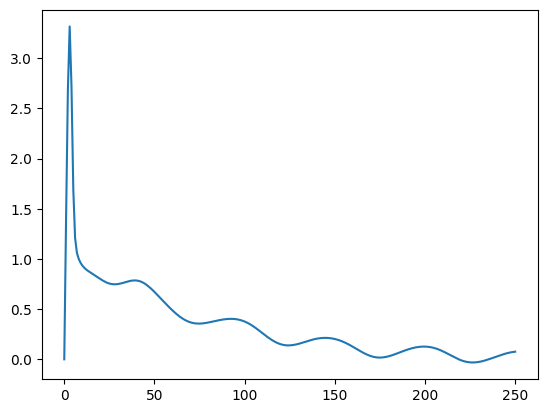

In [227]:
beta, cost_function, phi_list, eigenValues_p, num_graphs = exeFALQON(graphs, qubits)
plt.plot(beta)
plt.show()

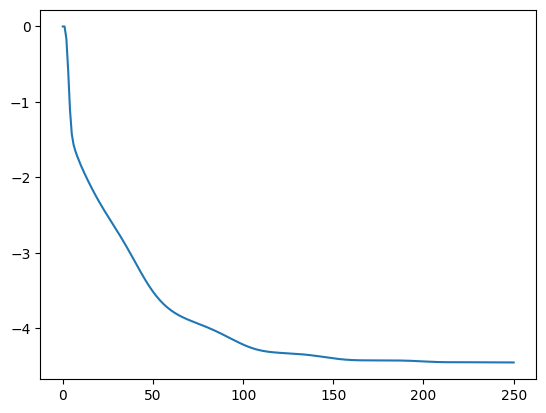

In [228]:
plt.plot(cost_function)
plt.show()

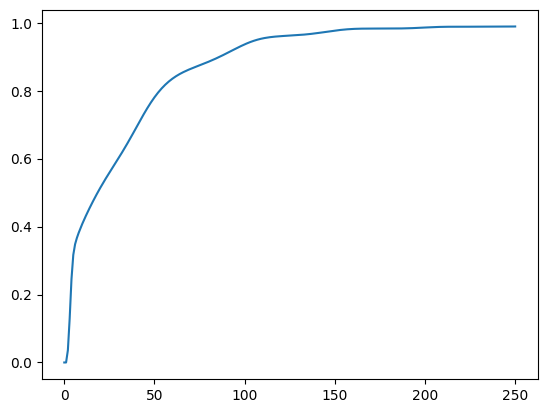

In [229]:
approximation_ratio = cost_function/eigenValues_p[0]
plt.plot(approximation_ratio)
plt.show()

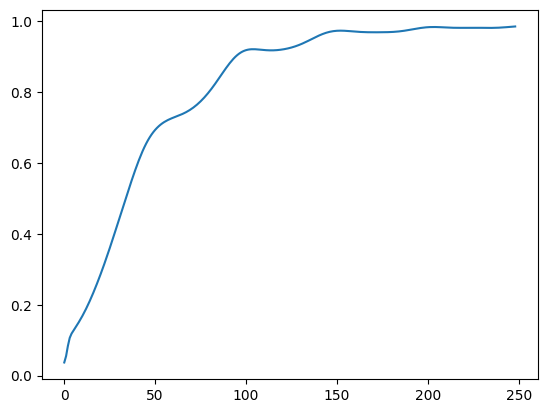

In [230]:
plt.plot(phi_list)
plt.show()

In [ ]:
#H_p = np.real(
#    ((np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*3/4) - (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) - (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
#     (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*3/4) - (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) - (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
#     (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*3/4) - (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*1/4) - (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
#     (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*3/4) - (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*1/4) - (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
#     (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*3/4) - (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) - (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25))) +
#     (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I)))) +
#      np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I)))) +
#      np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I)))) +
#      np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I)))) +
#      np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))))

In [ ]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
H1 = MaxClique_p(edges, 5, Z)

In [ ]:
H2 = np.real(
   (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*3/4) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*3/4) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*3/4) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*1/4) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*3/4) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*1/4) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*3/4))

In [ ]:
linalg.norm(H1-H2)
print(np.diag(H1).tolist(), np.diag(H2).tolist(), sep='\n')
np.diag(H1)/np.diag(H2)

In [ ]:
Cost Hamiltonian
  (-1.25) [Z3]
+ (-1.25) [Z4]
+ (-0.5) [Z0]
+ (0.25) [Z1]
+ (0.25) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z4]
+ (0.75) [Z1 Z3]
+ (0.75) [Z2 Z4]
+ (0.75) [Z3 Z4]

In [ ]:
len(beta)